<a href="https://colab.research.google.com/github/xSakix/AI_colab_notebooks/blob/master/imdb_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB DNN

Lets do the IMDB dataset with a simple DNN. I will do this one in numpy to have a baseline for comparing with later implementations in pytorch or tensorflow.

In [7]:
import keras
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)

In [2]:
def convert_to_array(x):
    x_temp = []

    for x in x_train:
        if len(x) < maxlen:
            for i in range(maxlen - len(x)):
                x.append(0.0)
        elif len(x) > maxlen:
            x = x[0:maxlen]

        x_temp.append(x)

    return np.array(x_temp)


def relu(z):
    return np.maximum(0, z)


def back_relu(Z, dA):
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    # normaly it would be:
    # Z[Z <= 0] = 0.
    # Z[Z > 0] = 1
    # dZ = dA*Z
    # so for short we have this
    dZ[Z <= 0.] = 0.
    # which says, that make dZ a copy od dA,then where Z <= 0 we have 0
    # and where Z > 0 we have 1*dA = dA
    return dZ


def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def back_sigmoid(Z, dA):
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

In [3]:
max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [4]:
x_train = convert_to_array(x_train)
x_val = convert_to_array(x_val)
y_train = y_train.reshape(y_train.shape[0], -1).T
y_val = y_val.reshape(y_val.shape[0], -1).T

x_train = x_train.reshape(x_train.shape[0], -1).T
x_val = x_val.reshape(x_val.shape[0], -1).T

print("*" * 80)
print("x_train:{}".format(x_train.shape))
print("x_val:{}".format(x_val.shape))
print("y_train:{}".format(y_train.shape))
print("y_val:{}".format(y_val.shape))
print("*" * 80)

assert (x_train.shape == (maxlen, 25000))
assert (y_train.shape == (1, 25000))
assert (x_val.shape == (maxlen, 25000))
assert (y_val.shape == (1, 25000))

print("*" * 80)

print("max x_train before:{}".format(np.max(x_train)))
print("max x_val before:{}".format(np.max(x_val)))
print("min before:{}, {}".format(np.min(x_train), np.min(x_val)))

# norm didn't work well
# norm = np.linalg.norm(x_train, ord=2)
# print("norm={}".format(norm))

# normalizing around max_features works well
# x_train = x_train / max_features
# x_val = x_val / max_features

# centering around mean
x_mean = np.mean(x_train)
x_std = np.std(x_train)
print("(mean,std)=({},{})".format(x_mean, x_std))
x_train = (x_train - x_mean) / x_std
x_val = (x_val - x_mean) / x_std

print("max x_train after norm:{}".format(np.max(x_train)))
print("max x_val after norm:{}".format(np.max(x_val)))
print("min after norm:{}, {}".format(np.min(x_train), np.min(x_val)))

# assert ((x_train >= 0.).all() and (x_train < 1.).all())

print("*" * 80)

print("y_train unique vals:{}".format(np.unique(y_train)))
print("y_val unique vals:{}".format(np.unique(y_train)))

print("*" * 80)

********************************************************************************
x_train:(200, 25000)
x_val:(200, 25000)
y_train:(1, 25000)
y_val:(1, 25000)
********************************************************************************
********************************************************************************
max x_train before:19999.0
max x_val before:19999.0
min before:0.0, 0.0
(mean,std)=(896.850569,2520.963839741494)
max x_train after norm:7.5773198845084515
max x_val after norm:7.5773198845084515
min after norm:-0.35575701438540475, -0.35575701438540475
********************************************************************************
y_train unique vals:[0 1]
y_val unique vals:[0 1]
********************************************************************************


In [5]:
# 2 layer network
m = x_train.shape[1]
n_x = x_train.shape[0]
n_h = 32
n_y = 1
# init params
W1 = np.random.randn(n_h, n_x) * 0.01
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(n_y, n_h) * 0.01
b2 = np.zeros((n_y, 1))

assert (W1.shape == (n_h, n_x))
assert (b1.shape == (n_h, 1))
assert (W2.shape == (n_y, n_h))
assert (b2.shape == (n_y, 1))

In [19]:
grads = {}
costs = []
n_iter = 20000
learning_rate = 0.1
# learning_rate = 0.01

for i in range(0, n_iter):
    # forward
    # A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
    # do a forward pass over relu
    # print("W1.shape:{}".format(W1.shape))
    # print("X.shape:{}".format(x_train.shape))
    # m x n * n x p = m x p
    # (5, 200) * (200, 25000)
    Z1 = np.dot(W1, x_train) + b1
    assert (Z1.shape == (n_h, m))
    A1 = relu(Z1)
    assert (A1.shape == (n_h, m))
    # A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
    Z2 = np.dot(W2, A1) + b2
    assert (Z2.shape == (n_y, m))
    A2 = sigmoid(Z2)
    assert (A2.shape == (n_y, m))

    # compute cost
    cost = -(1 / m) * np.sum(y_train * np.log(A2) + (1 - y_train) * np.log(1 - A2))
    cost = np.squeeze(cost)
    # backward compute loss
    dA2 = -(np.divide(y_train, A2) - np.divide(1 - y_train, 1 - A2))
    # print("dA2.shape={}".format(dA2.shape))
    assert (dA2.shape == A2.shape)
    # backward
    dZ2 = back_sigmoid(Z2, dA2)
    assert (dZ2.shape == dA2.shape)

    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)

    assert (dA1.shape == A1.shape)
    assert (dW2.shape == W2.shape)
    assert (db2.shape == b2.shape)

    dZ1 = back_relu(Z1, dA1)
    assert (dZ1.shape == dA1.shape)

    dW1 = (1 / m) * np.dot(dZ1, x_train.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    assert (dW1.shape == W1.shape)
    assert (db1.shape == b1.shape)

    # update params
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    # print stats
    if i % 100 == 0:
        print("Cost after iteration {}: {}".format(i, cost))
    if i % 100 == 0:
        costs.append(cost)


Cost after iteration 0: 0.3776650989414848
Cost after iteration 100: 0.38424954837406
Cost after iteration 200: 0.3851366410106382
Cost after iteration 300: 0.38171651976229837
Cost after iteration 400: 0.3799193005629154
Cost after iteration 500: 0.38158585603124334
Cost after iteration 600: 0.38408473106142754
Cost after iteration 700: 0.3833394788054401
Cost after iteration 800: 0.3812170050552372
Cost after iteration 900: 0.37989602320862215
Cost after iteration 1000: 0.3790547638056694
Cost after iteration 1100: 0.3787988138040701
Cost after iteration 1200: 0.3789847649557314
Cost after iteration 1300: 0.3795075736080541
Cost after iteration 1400: 0.3805155277240294
Cost after iteration 1500: 0.38183609702319193
Cost after iteration 1600: 0.3826889944670011
Cost after iteration 1700: 0.3826227876718929
Cost after iteration 1800: 0.381302284962674
Cost after iteration 1900: 0.37971950819614225
Cost after iteration 2000: 0.3787695313465541
Cost after iteration 2100: 0.37810907578611

[0.5830089  0.02398047 0.55155607 0.99911506 0.13190183 0.39991956
 0.86403724 0.12378528 0.9682377  0.38528058]
[1 0 1 1 0 0 1 0 1 0]
[0 1 1 0 1 1 1 0 0 1]
Accuracy: 0.50004


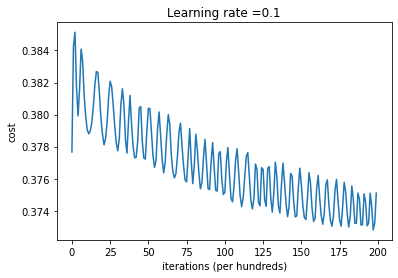

In [20]:
#predict
p = np.zeros((1, x_val.shape[1]),dtype=int)

#compute forward 
Z1 = np.dot(W1, x_val) + b1
A1 = relu(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = sigmoid(Z2)

print(A2[0,:10])

# convert probas to 0/1 predictions
for i in range(0, A2.shape[1]):
    if A2[0, i] > 0.5:
        p[0, i] = 1
    else:
        p[0, i] = 0


print(p[0,:10])
print(y_val[0,:10])

print("Accuracy: " + str(np.sum((p == y_val)/x_val.shape[1])))

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

# summary

Kinda works, but is really slow. So i'm gonna switch to pytorch and GPU.

The learning rate can be initialy big (0.1), but later on lets say after 20-30k iterations it starts to diverge to much. So 0.01 is more appropriate.